# Gaia Data for M67

<i>[Gaia](http://sci.esa.int/gaia/) is an [ESA](http://www.esa.int/ESA) satellite aiming to chart a three-dimensional map of our Galaxy, the Milky Way.  On 13 June 2022, Gaia had it's third data release, [DR3](https://www.cosmos.esa.int/web/gaia/dr3), that contains positions and velocities for over a billion stars.  We will use a subset of these data here, for a specific [open star cluster](https://en.wikipedia.org/wiki/Open_cluster) [M67](https://en.wikipedia.org/wiki/Messier_67)

This workshop builds off of the tutorial here: https://www.cosmos.esa.int/web/gaia-users/archive/use-cases#datalink_dr3_pleiades


Author: Aaron Geller <br/> June 2018, updated June 2022</i>


*First, we import all the required python modules:*

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import numpy as np
from functools import reduce
from scipy import stats
from astropy.modeling import models, fitting

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm

In [3]:
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

*Do the following to load and look at the available Gaia table names:*

*Note: The main table is gaiadr3.gaia_source, and [here](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html) is the description of the columns*

In [4]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.catwise2020
external.external.gaiadr2_astrophysical_parameters
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.gaiaedr3_gcns_main_1
external.external.gaiaedr3_gcns_rejected_1
external.external.gaiaedr3_spurious
external.external.gaia_eso_survey
external.external.galex_ais
external.external.lamost_dr9_lrs
external.external.lamost_dr9_mrs
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.ravedr6
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
external.external.xgboost_table1
external.external.xgboost_table2
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_ze

In [5]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
for column in (gaiadr3_table.columns):
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

*Next, we retrieve all the available data in the region of interest.*

*To do this we perform an asynchronous query (asynchronous rather than synchronous queries should be performed when retrieving more than 2000 rows) centred on the M67 (coordinates: RA = 132.825 deg, +11.8167) with a search radius of 1 degrees*

*We'll also require that the proper motion errors are small, and the data is well behaved*

*Note: The query to the archive is with ADQL (Astronomical Data Query Language). For a description of ADQL and more examples see the Gaia DR1 ADQL cookbook: https://gaia.ac.uk/data/gaia-data-release-1/adql-cookbook*

In [6]:
cmd = "SELECT * FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec),\
    CIRCLE('ICRS', 132.825, 11.8167, 1))=1\
    AND abs(pmra_error)<5 \
    AND abs(pmdec_error)<5 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0;"

job = Gaia.launch_job_async(cmd, dump_to_file=False) #could save this to a file

print (job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=16958>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique

*Inspect the output table and number of rows (Note: if we didn't supress the warnings, there would be a lot of them here).*

In [7]:
r = job.get_results()
print(len(r))
print(r)

16958
    solution_id             DESIGNATION         ... libname_gspphot
                                                ...                
------------------- --------------------------- ... ---------------
1636148068921376768 Gaia DR3 598663847733780864 ...                
1636148068921376768 Gaia DR3 598665153403811584 ...                
1636148068921376768 Gaia DR3 598642613415506816 ...                
1636148068921376768 Gaia DR3 598613682515718656 ...                
1636148068921376768 Gaia DR3 598614782028709376 ...                
1636148068921376768 Gaia DR3 598615293128513664 ...                
1636148068921376768 Gaia DR3 598615464927206656 ...                
1636148068921376768 Gaia DR3 598615464931821824 ...                
1636148068921376768 Gaia DR3 598615568006211456 ...                
1636148068921376768 Gaia DR3 598615572300763648 ...                
                ...                         ... ...             ...
1636148068921376768 Gaia DR3 6079901415885

*Plot the color-magnitude diagram (CMD), using the "BP" and "RP" magnitudes*

Text(0, 0.5, 'RP')

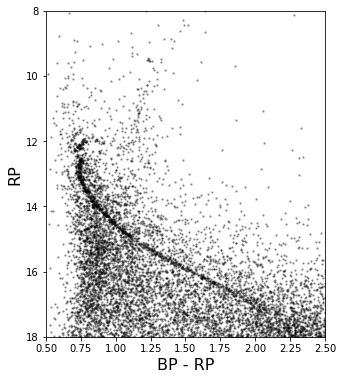

In [8]:
f = plt.figure(figsize=(5,6))
plt.scatter(r['bp_rp'], r['phot_rp_mean_mag'], s = 2, color = 'black', alpha = 0.3)
plt.xlim(0.5,2.5)
plt.ylim(18, 8)
plt.xlabel('BP - RP', fontsize=16)
plt.ylabel('RP', fontsize=16)

## Identify the cluster members

### The first thing we might want to look at is the radial velocities.  

*The [radial velocity](https://en.wikipedia.org/wiki/Radial_velocity) is the speed at which an object is moving toward or away from us.  For a star cluster, all the stars will move with a similar radial-velocity, while the field stars will have a much broader distribution*


*Plot a histogram of the radial velocities (the key is "radial_velocity") from our M67 Gaia catalog.*

Text(0.5, 0, 'RV (km s$^{-1}$)')

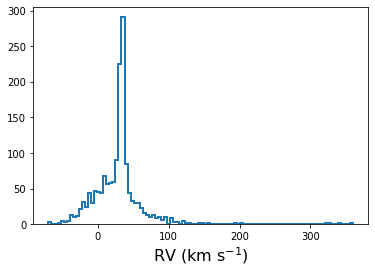

In [9]:
hrv, brv, im = plt.hist(r['radial_velocity'], bins = 100, histtype='step', fill=False, linewidth=2)
plt.xlabel(r'RV (km s$^{-1}$)', fontsize = 16)

*$\texttt{astropy}$ has some really great fitting features.  See [this documention about modeling](http://docs.astropy.org/en/stable/modeling/).  For the radial velocities, we want to fit two [1D Gaussians](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian1D.html) to the data, using $\texttt{astropy}$.  The first Gaussian is for the cluster (that narrow, peaked distribution).  The second is for the field.*

*We will do this below.  You will probably want to supply initial guesses for the parameters.  When you have the fit, plot the fit on top of the radial-velocity histogram.*


Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=266.60072439, mean=32.09140986, stddev=3.00848127)>

    [1]: <Gaussian1D(amplitude=60.06045127, mean=18.10611113, stddev=29.56900532)>
Parameters:
       amplitude_0           mean_0      ...       mean_1            stddev_1     
    ------------------ ----------------- ... ------------------ ------------------
    266.60072439048747 32.09140986311344 ... 18.106111133986992 29.569005319778906


Text(0.5, 0, 'RV (km s$^{-1}$)')

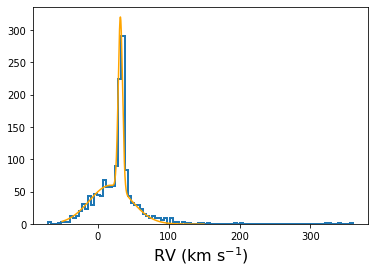

In [11]:
#fit
p_init = models.Gaussian1D(np.max(hrv), brv[np.argmax(hrv)], 1) + models.Gaussian1D(5, brv[np.argmax(hrv)], 50)
fit_p = fitting.LevMarLSQFitter()
rvG1D = fit_p(p_init, brv[:-1], hrv)
print(rvG1D)

#plot
foo = plt.hist(r['radial_velocity'], bins = 100, histtype='step', fill=False, linewidth=2)
x = np.linspace(-50, 150, 1000)
plt.plot(x,rvG1D(x), color='orange')
plt.xlabel(r'RV (km s$^{-1}$)', fontsize = 16)

*Now we can calculate formal membership probabilities with the following formula*

$$
P\left(v\right) = \frac{F_\mathrm{cluster}\left(v\right)}{F_\mathrm{cluster}\left(v\right) + F_\mathrm{field}\left(v\right)}
$$

*Here, $F_\mathrm{cluster}\left(v\right)$ and $F_\mathrm{field}\left(v\right)$ are the cluster (narrow) and field (broad) components of our two-component Gaussian model. Use this formula below.  Then plot a histogram of the $P\left(v\right)$ distribution. Stars with $P\left(v\right) \sim 1$ are high-probability members, while those with $P\left(v\right) \sim 0$ are non-members.  You will want to pick some cutoff to select the members. Then use $\texttt{numpy.where}$ to get the indices of these radial-velocity members.  You may also want to plot a CMD to look at them.*

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
    ------------------ ----------------- -----------------
    266.60072439048747 32.09140986311344 3.008481274998411


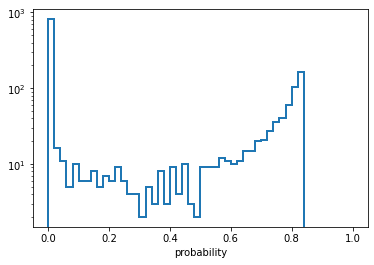

In [15]:
#membership calculation
Fc = models.Gaussian1D()
Fc.parameters = rvG1D.parameters[0:3]
print(Fc)
PRV = Fc(r['radial_velocity'])/rvG1D(r['radial_velocity'])

#plot
b, h, im = plt.hist(PRV, bins = 50, histtype='step', fill=False, range=(0,1), linewidth=2)
plt.yscale('log')
plt.xlabel('probability')

#where statement
membersRV = np.where(np.logical_and(PRV > 0.5, r['radial_velocity'].mask == False))
membersRVAll = np.where(PRV > 0.5)


### Now let's check the parallaxes.

<i>[Parallax](https://en.wikipedia.org/wiki/Parallax) is a displacement of an object, with respect to background objects, when viewed from different positions.  Parallax can be used to measure the distance to an object.  Once again, $\texttt{astropy}$ has a great utility for this.

Plot a histogram of the distances.</i>

Text(0.5, 0, 'distance (pc)')

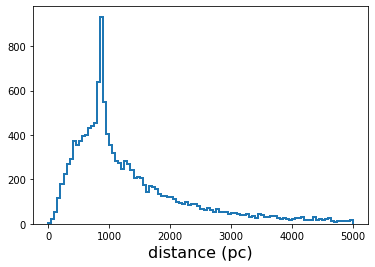

In [13]:
dist = (r['parallax']).to(u.parsec, equivalencies=u.parallax())
hpa, bpa, im = plt.hist(dist.to(u.parsec).value, bins = 100, histtype='step', fill=False, range=(0, 5000), linewidth=2)
plt.xlabel('distance (pc)', fontsize = 16)

*Now we want to fit the data again, so that we can derive cluster memberships based on distance.  Formally, there is no reason to think the cluster should be a Guassian distribution. (It should be fit with a "[King model](http://adsabs.harvard.edu/abs/1962AJ.....67..471K)".)  But let's approximate this by a 1D Gaussian.  Then we can fit the rest of the field with a simple polynomial.*

*Perform this fit to the distance, using $\texttt{astropy}$.  I suggest using a polynomial of degree 6 for the field. Plot the fit on top of the histogram of distances.*

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=555.09131938, mean=845.4403028, stddev=37.7953155)>

    [1]: <Polynomial1D(6, c0=-68.47106039, c1=1.80353673, c2=-0.00240911, c3=0.00000134, c4=-0., c5=0., c6=-0.)>
Parameters:
       amplitude_0         mean_0      ...          c6_1         
    ----------------- ---------------- ... ----------------------
    555.0913193768544 845.440302795935 ... -2.895681426137618e-18
[ 5.55091319e+02  8.45440303e+02  3.77953155e+01 -6.84710604e+01
  1.80353673e+00 -2.40911313e-03  1.34146714e-06 -3.76069855e-10
  5.24434846e-14 -2.89568143e-18]


Text(0.5, 0, 'distance (pc)')

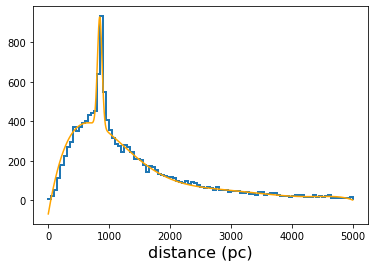

In [14]:
#fit
p_init = models.Gaussian1D(np.max(hpa), bpa[np.argmax(hpa)], 50) + models.Polynomial1D(degree=6)
fit_p = fitting.LevMarLSQFitter()
pa1D = fit_p(p_init, bpa[:-1], hpa)
print(pa1D)
print(pa1D.parameters)

#plot
foo = plt.hist(dist.to(u.parsec).value, bins = 100, histtype='step', fill=False, range=(0, 5000), linewidth=2)
x = np.linspace(0, 5000, 10000)
plt.plot(x,pa1D(x), color='orange')
plt.xlabel('distance (pc)', fontsize = 16)

*Do another membership calculation, using the same formula written above.  Plot a histogram of your membership probabilities.  Pick some cutoff to define the cluster members, and create another $\texttt{numpy.where}$ statement to hold the members you find from parallax.*

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude           mean             stddev      
    ----------------- ---------------- ------------------
    555.0913193768544 845.440302795935 37.795315498836246


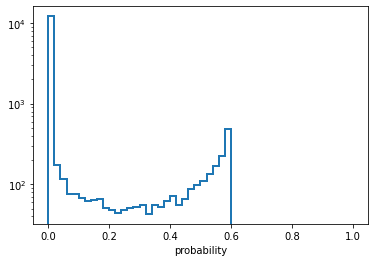

In [16]:
#membership calculation
Fc = models.Gaussian1D()
Fc.parameters = pa1D.parameters[0:3]
print(Fc)
x = dist.to(u.parsec).value
Ppa = Fc(x)/pa1D(x)

#plot
b, h, im = plt.hist(Ppa, bins = 50, histtype='step', fill=False, range=(0,1), linewidth=2)
plt.yscale('log')
plt.xlabel('probability')

#where statement
membersPa = np.where(np.logical_and(Ppa > 0.3, r['parallax'].mask == False))
membersPaAll = np.where(Ppa > 0.3)

### Now let's look at the proper motions.

*The [proper motion](https://en.wikipedia.org/wiki/Proper_motion) is the velocity that an objects moves along the plane of the sky (perpedicular to the radial velocity).  Proper motions are usually measured in mas / yr, which can be converted to km/s if you know the distance.*

*Let's start by plotting the proper motion in RA ("pmra") versus proper motion in DEC ("pmdec").*

(-20.0, 20.0)

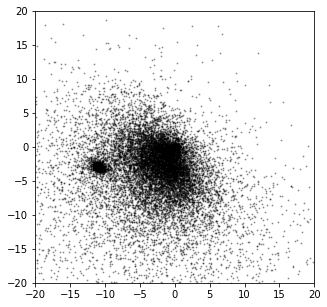

In [17]:
f = plt.figure(figsize=(5,5))
plt.scatter(r['pmra'], r['pmdec'], s=1, color='black', alpha = 0.3)
plt.xlim(-20,20)
plt.ylim(-20,20)


*Usually we like to show $\mathrm{RA} \cos(\mathrm{Dec})$, because these are coordinates on a sphere.*

*Plot this as a 2D histogram (aka heatmap).  I recommend using $\texttt{pyplot.hist2d}$.  Also make plots of the histograms of each of the proper motion directions. (Hint: you may want to define a method to do this, because you'll need to replot this all again below when you perform the fit.)*

311.0


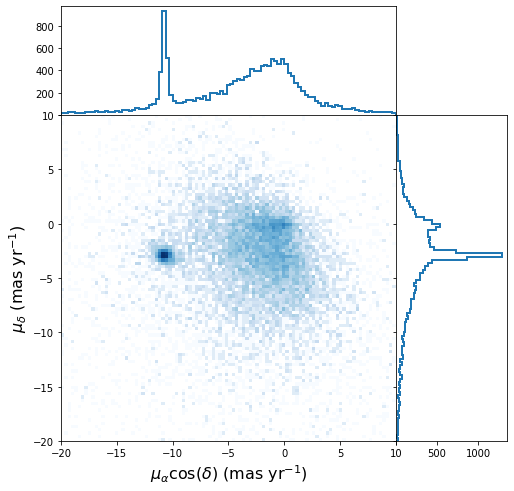

In [19]:
def plotPM(pmra, pmdec, dec, xmin, xmax, Nx, ymin, ymax, Ny, norm = None):
    f = plt.figure(figsize=(8, 8)) 
    gs = gridspec.GridSpec(2, 2, height_ratios = [1, 3], width_ratios = [3, 1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    #histograms
    pmRAbins = np.linspace(xmin,xmax,Nx)
    pmDecbins = np.linspace(ymin,ymax,Ny)
    hx1D, x1D, im = ax1.hist(pmra*np.cos(dec*np.pi/180.), bins=pmRAbins, histtype='step', fill=False, linewidth=2)
    hy1D, y1D, im = ax3.hist(pmdec, bins=pmDecbins, histtype='step', fill=False, orientation="horizontal", linewidth=2)

    #heatmap
    #ax2.hexbin(r['pmra']*np.cos(r['dec']*np.pi/180.), r['pmdec'], gridsize=30, cmap=cm.Blues, bins='log', extent=(xmin, xmax, ymin, ymax))
    h2D, x2D, y2D, im = ax2.hist2d(pmra*np.cos(dec*np.pi/180.), pmdec, bins=[Nx, Ny], \
                                    range=[[xmin, xmax], [ymin, ymax]], norm = norm, cmap = cm.Blues)
    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax3.set_ylim(ymin, ymax)
    ax2.set_xlabel(r'$\mu_\alpha \cos(\delta)$ (mas yr$^{-1}$)', fontsize=16)
    ax2.set_ylabel(r'$\mu_\delta$ (mas yr$^{-1}$)', fontsize=16)
    plt.setp(ax1.get_yticklabels()[0], visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels()[0], visible=False)
    f.subplots_adjust(hspace=0., wspace=0.)

    return x2D, y2D, h2D, x1D, hx1D, y1D, hy1D, (ax1, ax2, ax3)

xmin, xmax, Nx = -20, 10, 100
ymin, ymax, Ny = -20, 10, 100
x2D, y2D, h2D, x1D, hx1D, y1D, hy1D, ax = plotPM(r['pmra'], r['pmdec'], r['dec'], xmin, xmax, Nx, ymin, ymax, Ny, norm=mpl.colors.LogNorm())
print(np.max(h2D.flatten()))

*For the proper motions, we will fit two [2D Gaussians](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Gaussian2D.html) to the data, using $\texttt{astropy}$*

*Perform this fit and plot it on top of your 2D histogram, as well as your 1D histograms.*

[ 4.17392366e+02 -1.08780807e+01 -3.06518560e+00  2.33341904e-01
  2.40461271e-01 -1.91950886e+10  1.45856215e+01 -1.94617369e+00
 -2.27108774e+00  3.40630859e+00  2.98175670e+00  1.31420102e+09]


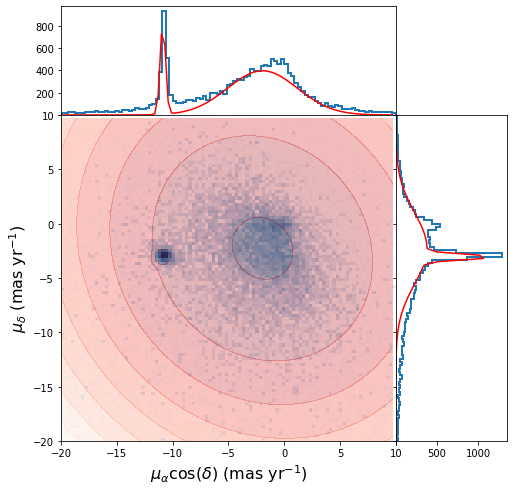

In [24]:
#fit
p_init = models.Gaussian2D(np.max(h2D.flatten()), x1D[np.argmax(hx1D)], y1D[np.argmax(hy1D)], 1, 1)\
        + models.Gaussian2D(np.max(h2D.flatten()), 0, 0, 5, 5)
fit_p = fitting.LevMarLSQFitter()
x, y = np.meshgrid(x2D[:-1], y2D[:-1], indexing='ij')
pmG2D = fit_p(p_init, x, y, h2D)
#print(pmG2D)
print(pmG2D.parameters)

#plots
_,_,_,_,_,_,_,ax = plotPM(r['pmra'], r['pmdec'], r['dec'], xmin, xmax, Nx, ymin, ymax, Ny, norm=mpl.colors.LogNorm())
ax1, ax2, ax3 = ax

ax2.contourf(x2D[:-1], y2D[:-1], pmG2D(x, y).T, cmap=cm.Reds, bins = 100, norm=mpl.colors.LogNorm(), alpha = 0.3, linewidth=2)
ax1.plot(x2D[:-1], np.sum(pmG2D(x, y), axis=1), color='red')
ax3.plot(np.sum(pmG2D(x, y), axis=0), y2D[:-1], color='red')

*Calculate formal membership probabilities, using the same formula as above.  Plot a histogram of these proper-motion membership probabilities. Then write another $\texttt{numpy.where}$ statement to identify the indices of the proper-motion members.*


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean       ...       y_stddev            theta       
    ----------------- ------------------- ... ------------------- ------------------
    417.3923663707554 -10.878080655401424 ... 0.24046127125918768 -19195088580.20213


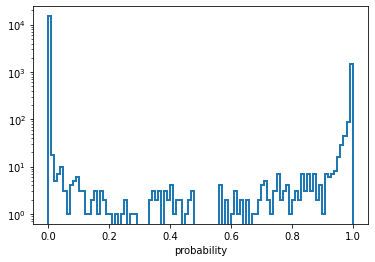

In [26]:
#membership probabilities
Fc = models.Gaussian2D()
Fc.parameters = pmG2D.parameters[0:6]
print(Fc)
x = r['pmra']*np.cos(r['dec']*np.pi/180.)
y = r['pmdec']
PPM = Fc(x,y)/pmG2D(x,y)

#plot
b, h, im = plt.hist(PPM, bins = 100, histtype='step', fill=False, range=(0,1), linewidth=2)
plt.yscale('log')
plt.xlabel('probability')

#where statement
membersPM = np.where(PPM > 0.5)


### Now, get a final list of members and plot the CMD

*Let's combine all of these different membership lists to get the intersection -- the stars that are members by radial velocity, parallax, and proper motion.  We can do this with $\texttt{numpy.intersect1d}$ and $\texttt{reduce}$; see [here](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.intersect1d.html).*

*After you create this member list, plot the CMD, showing* 
* *All the stars in the catalog,*
* *The stars identified as proper-motion members*
* *The stars identified as radial-velocity members*
* *The stars identified as members from parallax*
* *The final list of members*

*I suggest that you make more than one plot, so that you can see the different samples.*

*Also, note that, for M67, the radial velocities are only available for the brightest stars.  If a star does not have a radial-velocity it can still be considered a member from the other methods, and, if so, should be included in the final member list.*


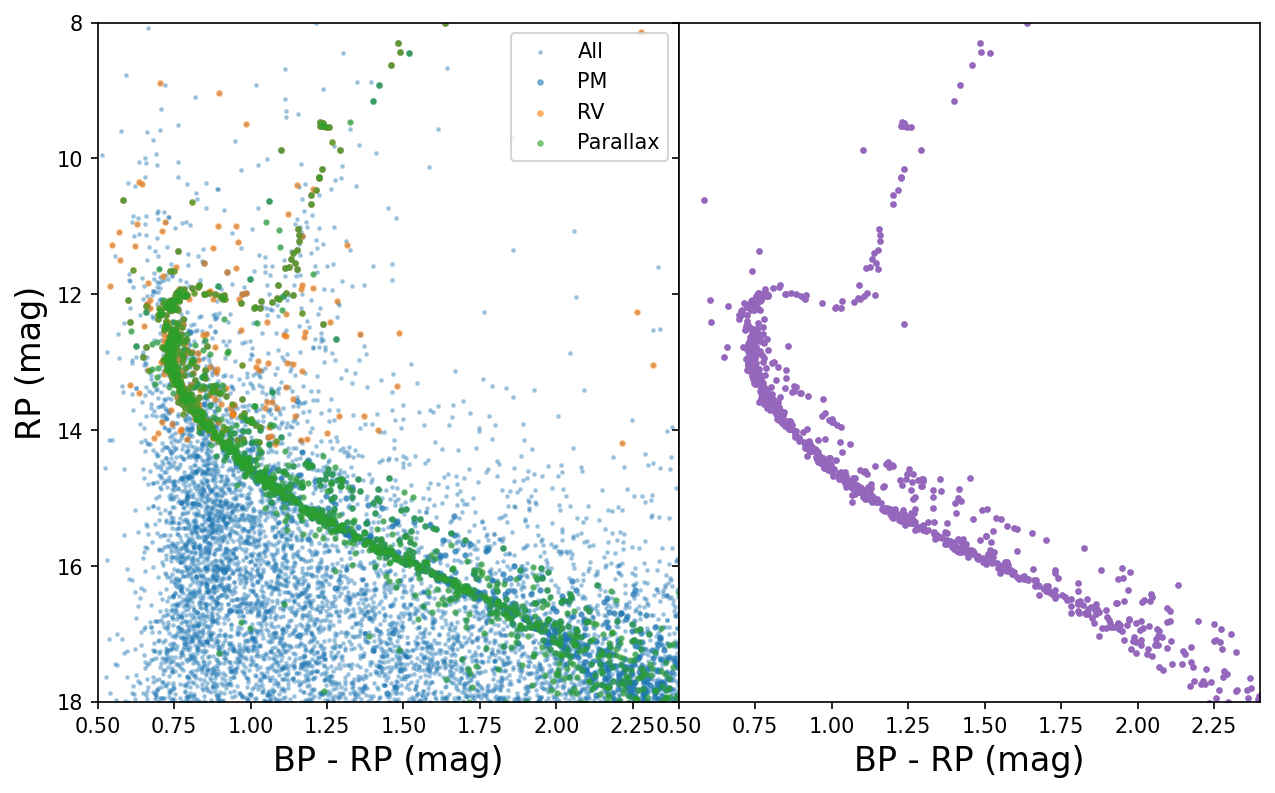

In [36]:
#intersection for all members
members = reduce(np.intersect1d, (membersPM, membersRVAll, membersPaAll))

#the plots
f, ax = plt.subplots(1,2, figsize=(10,6), dpi=150, sharey=True)
ax[0].scatter(r['bp_rp'], r['phot_rp_mean_mag'], s = 2,  color='C0', alpha = 0.3, label='All')
ax[0].scatter(r['bp_rp'][membersPM], r['phot_rp_mean_mag'][membersPM], s = 5, alpha=0.5, label='PM')
ax[0].scatter(r['bp_rp'][membersRV], r['phot_rp_mean_mag'][membersRV], s = 5, alpha=0.5, label='RV')
ax[0].scatter(r['bp_rp'][membersPa], r['phot_rp_mean_mag'][membersPa], s = 5, alpha=0.5, label='Parallax')
#ax[0].scatter(r['bp_rp'][members], r['phot_rp_mean_mag'][members], s = 5, color='C4',  label='Combined')
ax[0].legend()
ax[0].set_xlim(0.5,2.4)
ax[0].set_ylim(18, 8)
ax[0].set_xlabel('BP - RP (mag)', fontsize=16)
ax[0].set_ylabel('RP (mag)', fontsize=16)

ax[1].scatter(r['bp_rp'][members], r['phot_rp_mean_mag'][members], s = 5,  color='C4')
ax[1].set_xlim(0.5,2.4)
ax[1].set_ylim(18, 8)
ax[1].set_xlabel('BP - RP (mag)', fontsize=16)

plt.subplots_adjust(wspace=0)

## Pull this together to create a Class

*You can find information about Python Classes [here](https://docs.python.org/3/tutorial/classes.html).  In general, a Class allows you to bundle a lot of functionality together to clean up your code.*

*Let's create a class that will take a star cluster's RA and DEC, and return all the members. I will set up the outline, and you should copy your code from above into the appropriate spots.*

*This should work for M67, but we'll see if it is general enough to work with any random star cluster.  Creating a code that has more general functionality is a goal of good coding practice.*

In [ ]:
class GaiaClusterMembers(object):
    '''
    This Class will grab data from the Gaia archive, and attempt to determine members using the 
    proper motions, radial velocities and parallaxes.  
    
    The user must provide the RA and Dec values, and the Class will return the full catalog and 
    the indices of the members.
    
    Note: in this code, each membership check builds on the previous one, using only the stars that 
    have passed the previous membership selection.  This may not be ideal, but appears to work better 
    than if I simply take all stars in each of the membership calculations.
    '''
    
    def __init__(self, *args,**kwargs):
    
        #required inputs
        self.RA = None
        self.Dec = None

        #parameters that the user could change
        self.radius = 1 #in degrees
        self.minPMerror = 5
        self.minRVmembership = 0.5
        self.minPMmembership = 0.5
        self.minPamembership = 0.3
        self.PaPolyD = 6
        self.verbosity = 1
        self.showPlots = False
        self.RVmin = -100. #km/s
        self.RVmax = 100. #km/s
        self.RVbins = 100
        self.dmin = 0. #parsecs
        self.dmax = 3000. #parsecs
        self.dbins = 200
        self.PMxmin = -200 #mas/yr
        self.PMxmax = 200 #mas/yr
        self.PMxbins = 400
        self.PMymin = -200 #mas/yr
        self.PMymax = 200 #mas/yr
        self.PMybins = 400  
        self.CMDxmin = 0.5
        self.CMDxmax = 2.5
        self.CMDymin = 18
        self.CMDymax = 8
        self.RVmean = None
        self.distance = None
        self.PMmean = [None, None]
        
        #outputs
        self.catalog = None
        self.members = None
        self.RVmembers = None
        self.PMmembers = None
        self.PAmembers = None
        self.dist = None
        
    def getGaiaData(self):
        if (self.verbosity > 0):
            print("Retrieving catalog ... ")
        cmd = f"SELECT * FROM gaiadr3.gaia_source \
        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec),\
        CIRCLE('ICRS', {self.RA}, {self.Dec}, {self.radius}))=1\
        AND abs(pmra_error)<{self.minPMerror} \
        AND abs(pmdec_error)<{self.minPMerror} \
        AND pmra IS NOT NULL AND abs(pmra)>0 \
        AND pmdec IS NOT NULL AND abs(pmdec)>0;"
        if (self.verbosity > 1):
            print(cmd)
        job = Gaia.launch_job_async(cmd, dump_to_file=False) #could save this to a file
        self.catalog = job.get_results()
        self.members = range(len(self.catalog))
        self.dist = (self.catalog['parallax']).to(u.parsec, equivalencies=u.parallax())
        
    def getRVMembers(self):
        if (self.verbosity > 0):
            print("Finding radial-velocity members ... ")
        
        x = self.catalog['radial_velocity']
        ind = np.where(self.dist.to(u.parsec).value < self.dmax)
        mem = np.intersect1d(self.members, ind)                                                                      
        xm = x[mem]
        
        #1D histogram (use the members here)
        hrv, brv = np.histogram(xm, bins = self.RVbins, range=(self.RVmin, self.RVmax))
        
        #fit
        RVguess = brv[np.argmax(hrv)]
        if (self.RVmean != None):
            RVguess = self.RVmean
        p_init = models.Gaussian1D(np.max(hrv), RVguess, 1) \
                + models.Gaussian1D(5, brv[np.argmax(hrv)], 50)
        fit_p = fitting.LevMarLSQFitter()
        rvG1D = fit_p(p_init, brv[:-1], hrv)
        if (self.verbosity > 1):
            print(rvG1D)
            print(rvG1D.parameters)

        if (self.showPlots):
            hrv, brv = np.histogram(xm, bins = self.RVbins, range=(self.RVmin, self.RVmax))
            plt.step(brv[:-1],hrv)
            xf = np.linspace(self.RVmin, self.RVmax, self.RVbins*10)
            plt.plot(xf,rvG1D(xf), color='red')
            plt.xlabel(r'RV (km s$^{-1}$)', fontsize = 16)
            plt.show()
            
        #membership calculation
        Fc = models.Gaussian1D()
        Fc.parameters = rvG1D.parameters[0:3]
        PRV = Fc(x)/rvG1D(x)

        self.RVmembers = np.where(np.logical_and(PRV > self.minRVmembership, self.catalog['radial_velocity'].mask == False))
        membersRVAll = np.where(PRV > self.minRVmembership)
        self.members = np.intersect1d(self.members, membersRVAll)

    def getParallaxMembers(self):
        if (self.verbosity > 0):
            print("Finding parallax members ... ")
            
        x = self.dist.to(u.parsec).value
        ind = np.where(self.dist.to(u.parsec).value < self.dmax)
        mem = np.intersect1d(self.members, ind)                                                                      
        xm = x[mem]
        
        #1D histogram (use the members here)
        hpa, bpa = np.histogram(xm, bins = self.dbins, range=(self.dmin, self.dmax))

        #fit
        dguess = bpa[np.argmax(hpa)]
        if (self.distance != None):
            dguess = self.distance
        p_init = models.Gaussian1D(np.max(hpa), dguess, 10)\
                + models.Polynomial1D(degree=self.PaPolyD)
        fit_p = fitting.LevMarLSQFitter()
        pa1D = fit_p(p_init, bpa[:-1], hpa)
        if (self.verbosity > 1):
            print(pa1D)
            print(pa1D.parameters)

        if (self.showPlots):
            hpa, bpa = np.histogram(xm, bins = self.dbins, range=(self.dmin, self.dmax))
            plt.step(bpa[:-1],hpa)
            xf = np.linspace(self.dmin, self.dmax, self.dbins*10)
            plt.plot(xf,pa1D(xf), color='red')
            plt.xlabel('distance (pc)', fontsize = 16)
            plt.show()
            
        #membership calculation
        Fc = models.Gaussian1D()
        Fc.parameters = pa1D.parameters[0:3]
        Ppa = Fc(x)/pa1D(x)

        self.PAmembers = np.where(np.logical_and(Ppa > self.minPamembership, self.catalog['parallax'].mask == False))
        membersPaAll = np.where(Ppa > self.minPamembership)
        self.members = np.intersect1d(self.members, membersPaAll)
        
    def getPMMembers(self):
        if (self.verbosity > 0):
            print("finding proper-motion members ...")
        
        x = self.catalog['pmra']*np.cos(self.catalog['dec']*np.pi/180.)
        y = self.catalog['pmdec']
        ind = np.where(self.dist.to(u.parsec).value < self.dmax)
        mem = np.intersect1d(self.members, ind)                                                                      
        xm = x[mem]
        ym = y[mem]
        
        #1D histograms (use the members here)          
        pmRAbins = np.linspace(self.PMxmin, self.PMxmax, self.PMxbins)
        pmDecbins = np.linspace(self.PMymin, self.PMymax, self.PMybins)
        hx1D, x1D = np.histogram(xm, bins=pmRAbins)
        hy1D, y1D = np.histogram(ym, bins=pmDecbins)

        #2D histogram
        h2D, x2D, y2D = np.histogram2d(xm, ym, bins=[self.PMxbins, self.PMybins], \
                                       range=[[self.PMxmin, self.PMxmax], [self.PMymin, self.PMymax]])
        
        #fit
        PMxguess = x1D[np.argmax(hx1D)]
        PMyguess = y1D[np.argmax(hy1D)]
        if (self.PMmean[0] != None):
            PMxguess = self.PMmean[0]
        if (self.PMmean[1] != None):
            PMyguess = self.PMmean[1]
        p_init = models.Gaussian2D(np.max(h2D.flatten()), PMxguess, PMyguess, 1, 1)\
                + models.Gaussian2D(np.max(h2D.flatten()), 0, 0, 5, 5)
        fit_p = fitting.LevMarLSQFitter()
        xf, yf = np.meshgrid(x2D[:-1], y2D[:-1], indexing='ij')
        pmG2D = fit_p(p_init, xf, yf, h2D)
        if (self.verbosity > 1):
            print(pmG2D)
            print(pmG2D.parameters)
            
        if (self.showPlots):
            f = plt.figure(figsize=(8, 8)) 
            gs = gridspec.GridSpec(2, 2, height_ratios = [1, 3], width_ratios = [3, 1]) 
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[2])
            ax3 = plt.subplot(gs[3])

            #histograms
            hx1D, x1D = np.histogram(xm, bins=pmRAbins)
            hy1D, y1D = np.histogram(ym, bins=pmDecbins)
            ax1.step(x1D[:-1], hx1D)
            ax1.plot(x2D[:-1], np.sum(pmG2D(xf, yf), axis=1), color='red')
            ax3.step(hy1D, y1D[:-1])
            ax3.plot(np.sum(pmG2D(xf, yf), axis=0), y2D[:-1], color='red')

            #heatmap
            h2D, x2D, y2D, im = ax2.hist2d(xm, ym, bins=[self.PMxbins, self.PMybins],\
                                           range=[[self.PMxmin, self.PMxmax], [self.PMymin, self.PMymax]], \
                                           norm = mpl.colors.LogNorm(), cmap = cm.Blues)
#             ax2.contourf(x2D[:-1], y2D[:-1], pmG2D(xf, yf).T, cmap=cm.Reds, bins = 20, \
#                          norm=mpl.colors.LogNorm(), alpha = 0.3)

            ax1.set_xlim(self.PMxmin, self.PMxmax)
            ax2.set_xlim(self.PMxmin, self.PMxmax)
            ax2.set_ylim(self.PMymin, self.PMymax)
            ax3.set_ylim(self.PMymin, self.PMymax)
            ax1.set_yscale("log")
            ax1.set_ylim(1, 2*max(hx1D))
            ax3.set_xscale("log")
            ax3.set_xlim(1, 2*max(hy1D))
            ax2.set_xlabel(r'$\mu_\alpha \cos(\delta)$ (mas yr$^{-1}$)', fontsize=16)
            ax2.set_ylabel(r'$\mu_\delta$ (mas yr$^{-1}$)', fontsize=16)
            plt.setp(ax1.get_yticklabels()[0], visible=False)
            plt.setp(ax1.get_xticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            plt.setp(ax3.get_xticklabels()[0], visible=False)
            f.subplots_adjust(hspace=0., wspace=0.)
            plt.show()

        #membership calculation
        Fc = models.Gaussian2D()
        Fc.parameters = pmG2D.parameters[0:6]
        PPM = Fc(x,y)/pmG2D(x,y)

        self.PMmembers = np.where(np.logical_and(PPM > self.minPMmembership, self.catalog['pmra'].mask == False))
        membersPMAll = np.where(PPM > self.minPMmembership)
        self.members = np.intersect1d(self.members, membersPMAll)
        
    def plotCMD(self):
        f = plt.figure(figsize=(5,6))
        plt.scatter(self.catalog['bp_rp'], self.catalog['phot_rp_mean_mag'], s = 1,  color='C0', alpha = 0.3, label='All')
        plt.scatter(self.catalog['bp_rp'][self.members], self.catalog['phot_rp_mean_mag'][self.members], s = 5, color='red',  label='Members')
        plt.legend()
        plt.xlim(self.CMDxmin, self.CMDxmax)
        plt.ylim(self.CMDymin, self.CMDymax)
        plt.xlabel('BP - RP (mag)', fontsize=16)
        plt.ylabel('RP (mag)', fontsize=16)
        plt.show()
        
    def runAll(self):
        self.getGaiaData()
        self.getRVMembers()
        self.getParallaxMembers()
        self.getPMMembers()
        if (self.showPlots):
            self.plotCMD()
        if (self.verbosity > 0):
            print("Done.")

*Test this with M67*

In [ ]:
#M67
GM = GaiaClusterMembers()
GM.RA = 132.825
GM.Dec = 11.8167
GM.showPlots = True
GM.runAll()


*Try using this Class for the open cluster [Pleiades](https://en.wikipedia.org/wiki/Pleiades).*

In [ ]:
#The Pleiades
GM = GaiaClusterMembers()
GM.RA = 56.85
GM.Dec = 24.1167
GM.showPlots = True
GM.CMDxmin, GM.CMDxmax, GM.CMDymin, GM.CMDymax = -0.5, 3.5, 18, 0
GM.runAll()

*Try using this Class for the open cluster <a href="https://en.wikipedia.org/wiki/Hyades_(star_cluster)">Hyades</a>.  This cluster is close, but much more spread out on the sky.  If your code doesn't work, see if you can make it work.*

In [ ]:
#the Hyades
GM = GaiaClusterMembers()
GM.RA = 66.75
GM.Dec = 15.867
GM.radius = 2
GM.RVmean = 39.1 #km/s
GM.distance = 49 #parsecs
GM.dmax = 100. #parsecs
GM.PMxmin, GM.PMxmax, GM.PMymin, GM.PMymax, GM.PMxbins, GM.PMybins= 75, 125, -50, 0, 50, 50
GM.CMDxmin, GM.CMDxmax, GM.CMDymin, GM.CMDymax = -0.5, 3.5, 18, 0
GM.showPlots = True
GM.runAll()


*Try using this Class for the open cluster [NGC 188](https://en.wikipedia.org/wiki/NGC_188).  This cluster is much farther away.  If your code doesn't work, see if you can make it work.*

In [ ]:
#NGC 188
GM = GaiaClusterMembers()
GM.RA = 12.108
GM.Dec = 85.255
GM.RVmean = -42.4 #km/s
GM.distance = 1700 #parsecs
GM.showPlots = True
GM.runAll()

